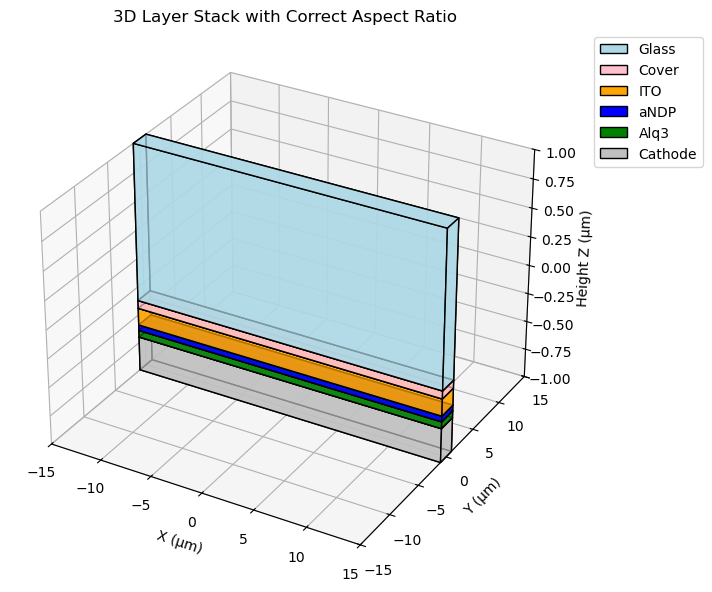

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Patch
import numpy as np

def set_axes_equal(ax):
    """Set 3D plot axes to equal scale."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()
    x_range = abs(x_limits[1] - x_limits[0])
    x_mid = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_mid = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_mid = np.mean(z_limits)
    plot_radius = 0.5 * max([x_range, y_range, z_range])
    ax.set_xlim3d([x_mid - plot_radius, x_mid + plot_radius])
    ax.set_ylim3d([y_mid - plot_radius, y_mid + plot_radius])
    ax.set_zlim3d([-1, 1])

# Layer definitions: (name, thickness, center_z, color)
layers_info = [
    ("Cathode",  0.3,  -0.85, "silver"),
    ("Alq3",     0.06, -0.67, "green"),
    ("aNDP",     0.05, -0.615, "blue"),
    ("ITO",      0.15, -0.515, "orange"),
    ("Cover",    0.07, -0.405, "pink"),
    ("Glass",    1.37,  0.315, "lightblue"),
]

# Plot extents
x_min, x_max = -15, 15
y_min, y_max = -1, 1

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

# Create geometry
legend_patches = []
for name, thickness, center_z, color in layers_info:
    z0 = center_z - thickness/2
    z1 = center_z + thickness/2
    
    verts = np.array([
        [x_min, y_min, z0],
        [x_max, y_min, z0],
        [x_max, y_max, z0],
        [x_min, y_max, z0],
        [x_min, y_min, z1],
        [x_max, y_min, z1],
        [x_max, y_max, z1],
        [x_min, y_max, z1],
    ])
    faces = [
        [verts[j] for j in [0,1,2,3]],
        [verts[j] for j in [4,5,6,7]],
        [verts[j] for j in [0,1,5,4]],
        [verts[j] for j in [1,2,6,5]],
        [verts[j] for j in [2,3,7,6]],
        [verts[j] for j in [3,0,4,7]],
    ]
    poly = Poly3DCollection(faces, facecolors=color, edgecolors='k', alpha=0.7)
    ax.add_collection3d(poly)
    legend_patches.append(Patch(facecolor=color, edgecolor='k', label=name))

# Axis labels and limits
ax.set_xlabel('X (µm)')
ax.set_ylabel('Y (µm)')
ax.set_zlabel('Height Z (µm)')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
zs = [c for _, _, c, _ in layers_info]
z_half = [t/2 for _, t, _, _ in layers_info]
ax.set_zlim(min(zs) - max(z_half), max(zs) + max(z_half))

# Equalize axes to get proper rectangular prism
set_axes_equal(ax)

# Legend with reversed order
legend_patches.reverse()
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title('3D Layer Stack with Correct Aspect Ratio')
plt.tight_layout()
plt.show()


In [25]:
import meep as mp
import numpy as np
import argparse

# ─────────────────────────────────────────────────────────────
# 1) 파라미터 파싱
# ─────────────────────────────────────────────────────────────
parser = argparse.ArgumentParser()
parser.add_argument("-res", type=int, default=50, help="resolution (pixels/µm)")
parser.add_argument("-nf",  type=int, default=500,help="number of frequencies")
parser.add_argument("-nt",  type=int, default=50, help="number of Monte Carlo trials")
parser.add_argument("-nb",  type=int, default=10, help="number of Fourier basis terms")
args = parser.parse_args()

# ─────────────────────────────────────────────────────────────
# 2) 공통 설정
# ─────────────────────────────────────────────────────────────
resolution = args.res
fcen       = 1.0      # 중심 주파수 (1/µm 단위)
df         = 0.2      # 대역폭
nfreq      = args.nf
run_time   = 2 * nfreq / df

# 셀 크기: width=15µm (x), height=2µm (y), z=0 (2D)
cell_size = mp.Vector3(15, 2, 0)

# PML
pml_layers = [mp.PML(thickness=1.0, direction=mp.Y)]

# Flux 모니터: 셀 상부(유리층 방향)로 나가는 플럭스
flux_region = mp.FluxRegion(center=mp.Vector3(0, +1.0, 0),
                            size=mp.Vector3(15, 0, 0))

# ─────────────────────────────────────────────────────────────
# 3) Method 1: Monte Carlo 랜덤 디폴
# ─────────────────────────────────────────────────────────────
def compute_flux_mc(ntrial):
    all_flux = np.zeros((nfreq, ntrial))
    for t in range(ntrial):
        # 랜덤 위상 디폴 Npx (=15*res)개를 한꺼번에 배치
        sources = []
        ndip = int(15 * resolution)
        for i in range(ndip):
            x = -7.5 + (i + 0.5) / resolution
            phase = 2*np.pi*np.random.rand()
            sources.append(
                mp.Source(
                    src=mp.GaussianSource(fcen, fwidth=df),
                    component=mp.Ez,
                    center=mp.Vector3(x, 0, 0),
                    amplitude=1,
                    phase=phase
                )
            )

        sim = mp.Simulation(cell_size=cell_size,
                            resolution=resolution,
                            boundary_layers=pml_layers,
                            sources=sources)
        flux_mon = sim.add_flux(fcen, df, nfreq, flux_region)
        sim.run(until=run_time)
        all_flux[:, t] = np.array(sim.get_fluxes(flux_mon))
    return all_flux.mean(axis=1)

# ─────────────────────────────────────────────────────────────
# 4) Method 3: 선형원 코사인 푸리에 기저
# ─────────────────────────────────────────────────────────────
def compute_flux_fourier(nbasis):
    all_flux = np.zeros((nfreq, nbasis))
    for m in range(nbasis):
        # 코사인 기저 함수
        def amp_func(p, m=m):
            L = 15
            cm = 1.0 if m == 0 else 2.0
            return cm * np.cos(m * np.pi * (p.x + 0.5*L) / L) / np.sqrt(L)

        sources = [
            mp.Source(
                src=mp.GaussianSource(fcen, fwidth=df),
                component=mp.Ez,
                center=mp.Vector3(0, 0, 0),
                size=mp.Vector3(15, 0, 0),
                amp_func=amp_func
            )
        ]

        sim = mp.Simulation(cell_size=cell_size,
                            resolution=resolution,
                            boundary_layers=pml_layers,
                            sources=sources)
        flux_mon = sim.add_flux(fcen, df, nfreq, flux_region)
        sim.run(until=run_time)
        all_flux[:, m] = np.array(sim.get_fluxes(flux_mon))
    return all_flux.mean(axis=1)

# ─────────────────────────────────────────────────────────────
# 5) 실행 및 결과 비교
# ─────────────────────────────────────────────────────────────
flux_mc    = compute_flux_mc(ntrial=args.nt)
flux_fourier = compute_flux_fourier(nbasis=args.nb)
freqs = mp.get_flux_freqs(mp.add_flux(fcen, df, nfreq, flux_region))  # 빈 flux for freqs

# ─────────────────────────────────────────────────────────────
# 6) 플롯
# ─────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

wls = 1/np.array(freqs)
plt.plot(wls, flux_mc,      'b-', label=f"MC (trials={args.nt})")
plt.plot(wls, flux_fourier, 'r--', label=f"Fourier (basis={args.nb})")
plt.xlabel("Wavelength (µm)")
plt.ylabel("Radiated Flux (arb. units)")
plt.legend()
plt.gca().invert_xaxis()  # 파장 짧→긴 방향 맞추기
plt.title("Method Comparison: MC vs. Fourier Basis")
plt.grid(True)
plt.show()


usage: ipykernel_launcher.py [-h] [-res RES] [-nf NF] [-nt NT] [-nb NB]
ipykernel_launcher.py: error: unrecognized arguments: --f=/run/user/1000/jupyter/runtime/kernel-v30f3e4b054baaa7cd7b1c9449b0fb4ae9e19da2d2.json


SystemExit: 2